['/data/maryam.sana/datazips/vimeo_septuplet/sequences/00026/0466/im1.png', '/data/maryam.sana/datazips/vimeo_septuplet/sequences/00026/0466/im2.png', '/data/maryam.sana/datazips/vimeo_septuplet/sequences/00026/0466/im3.png', '/data/maryam.sana/datazips/vimeo_septuplet/sequences/00026/0466/im4.png', '/data/maryam.sana/datazips/vimeo_septuplet/sequences/00026/0466/im5.png']
['/data/maryam.sana/datazips/vimeo_septuplet/sequences/00093/0264/im1.png', '/data/maryam.sana/datazips/vimeo_septuplet/sequences/00093/0264/im2.png', '/data/maryam.sana/datazips/vimeo_septuplet/sequences/00093/0264/im3.png', '/data/maryam.sana/datazips/vimeo_septuplet/sequences/00093/0264/im4.png', '/data/maryam.sana/datazips/vimeo_septuplet/sequences/00093/0264/im5.png']
['/data/maryam.sana/datazips/vimeo_septuplet/sequences/00078/0693/im1.png', '/data/maryam.sana/datazips/vimeo_septuplet/sequences/00078/0693/im2.png', '/data/maryam.sana/datazips/vimeo_septuplet/sequences/00078/0693/im3.png', '/data/maryam.sana/dat

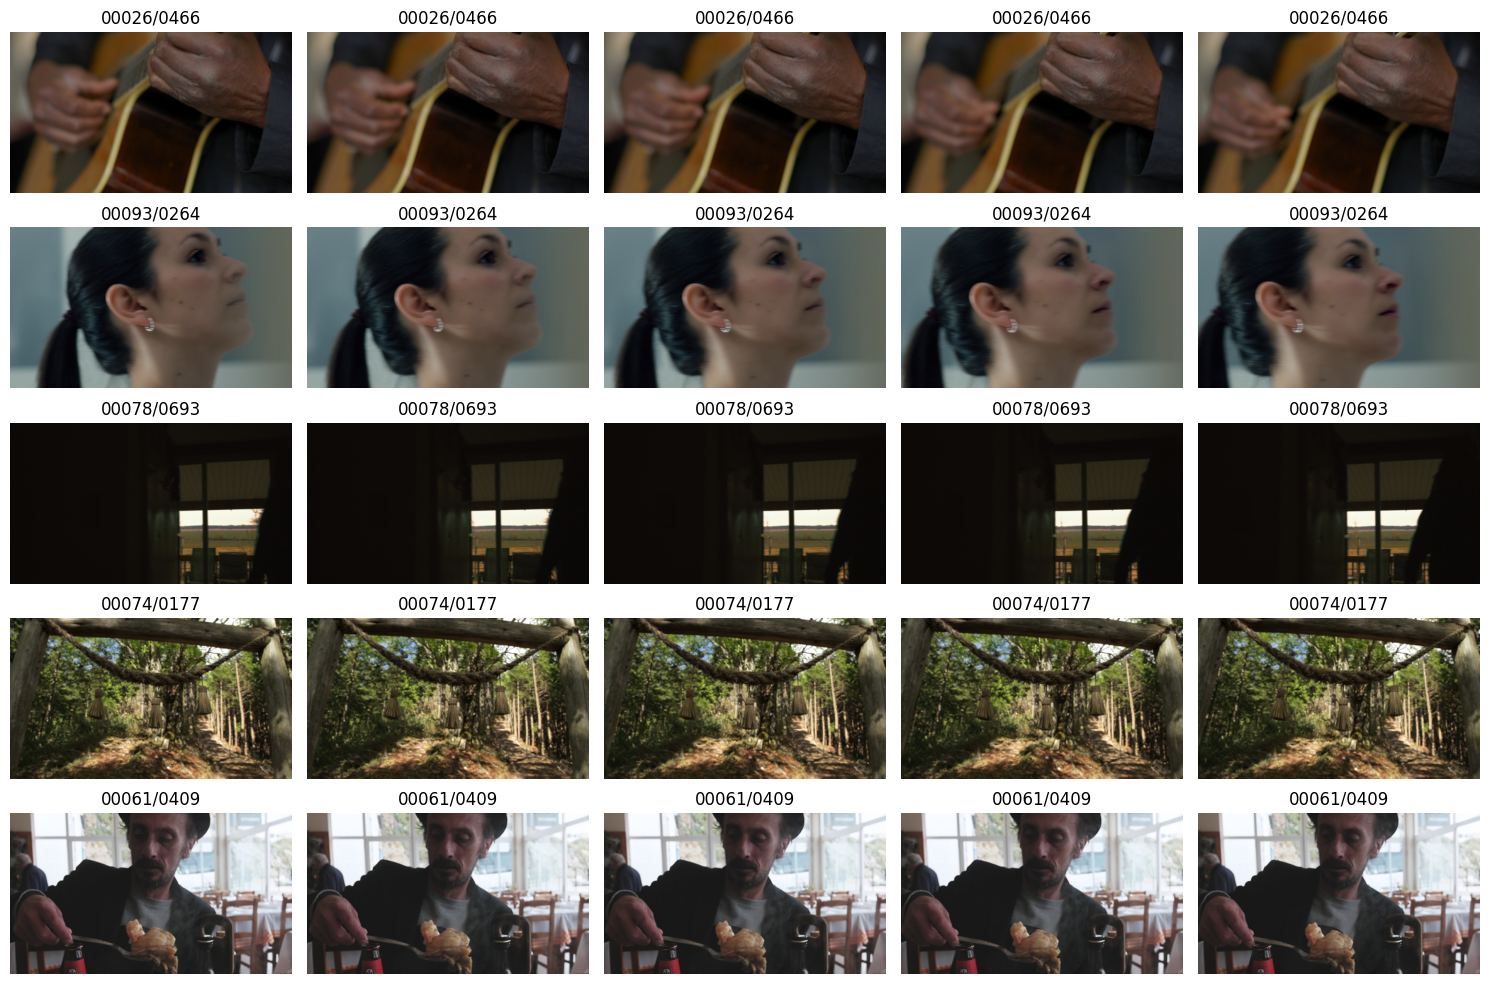

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random

# Set the path to the Vimeo dataset
dataset_path = "/data/maryam.sana/datazips/vimeo_septuplet/sequences/"

# Function to get list of video directories
def get_video_dirs(base_path):
    return sorted([d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))])

# Function to get list of sequence directories for a given video
def get_sequence_dirs(video_path):
    return sorted([d for d in os.listdir(video_path) if os.path.isdir(os.path.join(video_path, d))])

# Get the list of videos and sequences
video_dirs = get_video_dirs(dataset_path)

# Function to generate random video and sequence indices
def get_random_indices(video_dirs):
    video_dir = random.choice(video_dirs)
    video_path = os.path.join(dataset_path, video_dir)
    sequence_dirs = get_sequence_dirs(video_path)
    sequence_dir = random.choice(sequence_dirs)
    return video_dir, sequence_dir

# Function to get image paths for a given video and sequence
def get_image_paths(video_dir, sequence_dir):
    sequence_path = os.path.join(dataset_path, video_dir, sequence_dir)
    image_paths = [os.path.join(sequence_path, f"im{i}.png") for i in range(1, 6)]
    print(image_paths)
    return image_paths

# Pick 5 sequences randomly
random_sequences = [get_random_indices(video_dirs) for _ in range(5)]



# Plot the images
fig, axes = plt.subplots(5, 5, figsize=(15, 10))

for row, (video_dir, sequence_dir) in enumerate(random_sequences):
    image_paths = get_image_paths(video_dir, sequence_dir)
    for col, image_path in enumerate(image_paths):
        if os.path.exists(image_path):
            img = plt.imread(image_path)
            axes[row, col].imshow(img)
        axes[row, col].axis('off')
        axes[row, col].set_title(f"{video_dir}/{sequence_dir}")

plt.tight_layout()
plt.show()

In [2]:
import sys

if "./" not in sys.path:
    sys.path.append("./")
    
from utils.share import *
import utils.config as config

import einops
import gradio as gr
import numpy as np
import cv2
import torch
from pytorch_lightning import seed_everything

from annotator.util import resize_image, HWC3


from models.util import create_model, load_state_dict
from models.ddim_hacked import DDIMSampler
from src.test.test_vimeo_img2img import process

ModuleNotFoundError: No module named 'utils'

In [3]:
def process(
    original_image,
    prompt,
    a_prompt,
    n_prompt,
    num_samples,
    image_resolution,
    ddim_steps,
    strength,
    scale,
    seed,
    eta,
    global_strength,
):

    seed_everything(seed)

    with torch.no_grad():
        original_image = resize_image(HWC3(original_image), image_resolution)

        H, W, C = original_image.shape

        content_emb = np.zeros((768))

        detected_maps = np.concatenate([original_image], axis=2)

        local_control = torch.from_numpy(detected_maps.copy()).float().cuda() / 255.0
        local_control = torch.stack([local_control for _ in range(num_samples)], dim=0)
        local_control = einops.rearrange(local_control, "b h w c -> b c h w").clone()
        global_control = torch.from_numpy(content_emb.copy()).float().cuda().clone()
        global_control = torch.stack(
            [global_control for _ in range(num_samples)], dim=0
        )

        if config.save_memory:
            model.low_vram_shift(is_diffusing=False)

        uc_local_control = local_control
        uc_global_control = torch.zeros_like(global_control)
        cond = {
            "local_control": [local_control],
            "c_crossattn": [
                model.get_learned_conditioning([prompt + ", " + a_prompt] * num_samples)
            ],
            "global_control": [global_control],
        }
        un_cond = {
            "local_control": [uc_local_control],
            "c_crossattn": [model.get_learned_conditioning([n_prompt] * num_samples)],
            "global_control": [uc_global_control],
        }
        shape = (4, H // 8, W // 8)

        if config.save_memory:
            model.low_vram_shift(is_diffusing=True)

        model.control_scales = [strength] * 13
        samples, _ = ddim_sampler.sample(
            ddim_steps,
            num_samples,
            shape,
            cond,
            verbose=True,
            eta=eta,
            unconditional_guidance_scale=scale,
            unconditional_conditioning=un_cond,
            global_strength=global_strength,
        )

        if config.save_memory:
            model.low_vram_shift(is_diffusing=False)

        x_samples = model.decode_first_stage(samples)
        x_samples = (
            (einops.rearrange(x_samples, "b c h w -> b h w c") * 127.5 + 127.5)
            .cpu()
            .numpy()
            .clip(0, 255)
            .astype(np.uint8)
        )
        results = [x_samples[i] for i in range(num_samples)]

    return (results, [original_image])


In [9]:
from PIL import Image
import numpy as np

a_prompt = "best quality, extremely detailed"
n_prompt = "longbody, lowres, bad anatomy, bad hands, missing fingers, extra digit, fewer digits, cropped, worst quality, low quality"
num_samples = 1
image_resolution = 512
ddim_steps = 50
strength = 1
scale = 7.5
seed = 42
eta = 0.0
global_strength = 1

def get_recons_img(prompt, original_image, local_image):
    pred = process(local_image, prompt, a_prompt, n_prompt, num_samples, image_resolution, ddim_steps, strength, scale, seed, eta, global_strength)
    recons_img = pred[0][0]

    # Ensure the images are of the same size
    if original_image.shape != recons_img.shape:
        recons_img = cv2.resize(recons_img, (original_image.shape[1], original_image.shape[0]))

    # Calculate residue
    residue = original_image - recons_img

    return recons_img, residue

Global seed set to 42


['data/00096_0576/im1.png', 'data/00096_0576/im2.png', 'data/00096_0576/im3.png', 'data/00096_0576/im4.png', 'data/00096_0576/im5.png', 'data/00096_0576/im6.png', 'data/00096_0576/im7.png']
Selected timesteps for ddim sampler: [  1  21  41  61  81 101 121 141 161 181 201 221 241 261 281 301 321 341
 361 381 401 421 441 461 481 501 521 541 561 581 601 621 641 661 681 701
 721 741 761 781 801 821 841 861 881 901 921 941 961 981]
Selected alphas for ddim sampler: a_t: tensor([0.9983, 0.9804, 0.9609, 0.9398, 0.9171, 0.8930, 0.8674, 0.8404, 0.8121,
        0.7827, 0.7521, 0.7207, 0.6885, 0.6557, 0.6224, 0.5888, 0.5551, 0.5215,
        0.4882, 0.4552, 0.4229, 0.3913, 0.3605, 0.3308, 0.3023, 0.2750, 0.2490,
        0.2245, 0.2014, 0.1799, 0.1598, 0.1413, 0.1243, 0.1087, 0.0946, 0.0819,
        0.0705, 0.0604, 0.0514, 0.0435, 0.0365, 0.0305, 0.0254, 0.0210, 0.0172,
        0.0140, 0.0113, 0.0091, 0.0073, 0.0058]); a_(t-1): [0.99914998 0.99829602 0.98038077 0.96087277 0.93978298 0.91713792
 0.8

DDIM Sampler: 100%|██████████████████████████████| 50/50 [00:18<00:00,  2.63it/s]
Global seed set to 42


Saved residue image: data/00096_0576/im1_residue.png
Selected timesteps for ddim sampler: [  1  21  41  61  81 101 121 141 161 181 201 221 241 261 281 301 321 341
 361 381 401 421 441 461 481 501 521 541 561 581 601 621 641 661 681 701
 721 741 761 781 801 821 841 861 881 901 921 941 961 981]
Selected alphas for ddim sampler: a_t: tensor([0.9983, 0.9804, 0.9609, 0.9398, 0.9171, 0.8930, 0.8674, 0.8404, 0.8121,
        0.7827, 0.7521, 0.7207, 0.6885, 0.6557, 0.6224, 0.5888, 0.5551, 0.5215,
        0.4882, 0.4552, 0.4229, 0.3913, 0.3605, 0.3308, 0.3023, 0.2750, 0.2490,
        0.2245, 0.2014, 0.1799, 0.1598, 0.1413, 0.1243, 0.1087, 0.0946, 0.0819,
        0.0705, 0.0604, 0.0514, 0.0435, 0.0365, 0.0305, 0.0254, 0.0210, 0.0172,
        0.0140, 0.0113, 0.0091, 0.0073, 0.0058]); a_(t-1): [0.99914998 0.99829602 0.98038077 0.96087277 0.93978298 0.91713792
 0.89298052 0.86737001 0.84038192 0.81210774 0.78265446 0.75214338
 0.72070938 0.68849909 0.65566933 0.62238538 0.58881873 0.55514455
 0.5215

DDIM Sampler: 100%|██████████████████████████████| 50/50 [00:19<00:00,  2.61it/s]
Global seed set to 42


Saved residue image: data/00096_0576/im2_residue.png
Selected timesteps for ddim sampler: [  1  21  41  61  81 101 121 141 161 181 201 221 241 261 281 301 321 341
 361 381 401 421 441 461 481 501 521 541 561 581 601 621 641 661 681 701
 721 741 761 781 801 821 841 861 881 901 921 941 961 981]
Selected alphas for ddim sampler: a_t: tensor([0.9983, 0.9804, 0.9609, 0.9398, 0.9171, 0.8930, 0.8674, 0.8404, 0.8121,
        0.7827, 0.7521, 0.7207, 0.6885, 0.6557, 0.6224, 0.5888, 0.5551, 0.5215,
        0.4882, 0.4552, 0.4229, 0.3913, 0.3605, 0.3308, 0.3023, 0.2750, 0.2490,
        0.2245, 0.2014, 0.1799, 0.1598, 0.1413, 0.1243, 0.1087, 0.0946, 0.0819,
        0.0705, 0.0604, 0.0514, 0.0435, 0.0365, 0.0305, 0.0254, 0.0210, 0.0172,
        0.0140, 0.0113, 0.0091, 0.0073, 0.0058]); a_(t-1): [0.99914998 0.99829602 0.98038077 0.96087277 0.93978298 0.91713792
 0.89298052 0.86737001 0.84038192 0.81210774 0.78265446 0.75214338
 0.72070938 0.68849909 0.65566933 0.62238538 0.58881873 0.55514455
 0.5215

DDIM Sampler: 100%|██████████████████████████████| 50/50 [00:19<00:00,  2.61it/s]
Global seed set to 42


Saved residue image: data/00096_0576/im3_residue.png
Selected timesteps for ddim sampler: [  1  21  41  61  81 101 121 141 161 181 201 221 241 261 281 301 321 341
 361 381 401 421 441 461 481 501 521 541 561 581 601 621 641 661 681 701
 721 741 761 781 801 821 841 861 881 901 921 941 961 981]
Selected alphas for ddim sampler: a_t: tensor([0.9983, 0.9804, 0.9609, 0.9398, 0.9171, 0.8930, 0.8674, 0.8404, 0.8121,
        0.7827, 0.7521, 0.7207, 0.6885, 0.6557, 0.6224, 0.5888, 0.5551, 0.5215,
        0.4882, 0.4552, 0.4229, 0.3913, 0.3605, 0.3308, 0.3023, 0.2750, 0.2490,
        0.2245, 0.2014, 0.1799, 0.1598, 0.1413, 0.1243, 0.1087, 0.0946, 0.0819,
        0.0705, 0.0604, 0.0514, 0.0435, 0.0365, 0.0305, 0.0254, 0.0210, 0.0172,
        0.0140, 0.0113, 0.0091, 0.0073, 0.0058]); a_(t-1): [0.99914998 0.99829602 0.98038077 0.96087277 0.93978298 0.91713792
 0.89298052 0.86737001 0.84038192 0.81210774 0.78265446 0.75214338
 0.72070938 0.68849909 0.65566933 0.62238538 0.58881873 0.55514455
 0.5215

DDIM Sampler: 100%|██████████████████████████████| 50/50 [00:19<00:00,  2.60it/s]
Global seed set to 42


Saved residue image: data/00096_0576/im4_residue.png
Selected timesteps for ddim sampler: [  1  21  41  61  81 101 121 141 161 181 201 221 241 261 281 301 321 341
 361 381 401 421 441 461 481 501 521 541 561 581 601 621 641 661 681 701
 721 741 761 781 801 821 841 861 881 901 921 941 961 981]
Selected alphas for ddim sampler: a_t: tensor([0.9983, 0.9804, 0.9609, 0.9398, 0.9171, 0.8930, 0.8674, 0.8404, 0.8121,
        0.7827, 0.7521, 0.7207, 0.6885, 0.6557, 0.6224, 0.5888, 0.5551, 0.5215,
        0.4882, 0.4552, 0.4229, 0.3913, 0.3605, 0.3308, 0.3023, 0.2750, 0.2490,
        0.2245, 0.2014, 0.1799, 0.1598, 0.1413, 0.1243, 0.1087, 0.0946, 0.0819,
        0.0705, 0.0604, 0.0514, 0.0435, 0.0365, 0.0305, 0.0254, 0.0210, 0.0172,
        0.0140, 0.0113, 0.0091, 0.0073, 0.0058]); a_(t-1): [0.99914998 0.99829602 0.98038077 0.96087277 0.93978298 0.91713792
 0.89298052 0.86737001 0.84038192 0.81210774 0.78265446 0.75214338
 0.72070938 0.68849909 0.65566933 0.62238538 0.58881873 0.55514455
 0.5215

DDIM Sampler: 100%|██████████████████████████████| 50/50 [00:19<00:00,  2.60it/s]
Global seed set to 42


Saved residue image: data/00096_0576/im5_residue.png
Selected timesteps for ddim sampler: [  1  21  41  61  81 101 121 141 161 181 201 221 241 261 281 301 321 341
 361 381 401 421 441 461 481 501 521 541 561 581 601 621 641 661 681 701
 721 741 761 781 801 821 841 861 881 901 921 941 961 981]
Selected alphas for ddim sampler: a_t: tensor([0.9983, 0.9804, 0.9609, 0.9398, 0.9171, 0.8930, 0.8674, 0.8404, 0.8121,
        0.7827, 0.7521, 0.7207, 0.6885, 0.6557, 0.6224, 0.5888, 0.5551, 0.5215,
        0.4882, 0.4552, 0.4229, 0.3913, 0.3605, 0.3308, 0.3023, 0.2750, 0.2490,
        0.2245, 0.2014, 0.1799, 0.1598, 0.1413, 0.1243, 0.1087, 0.0946, 0.0819,
        0.0705, 0.0604, 0.0514, 0.0435, 0.0365, 0.0305, 0.0254, 0.0210, 0.0172,
        0.0140, 0.0113, 0.0091, 0.0073, 0.0058]); a_(t-1): [0.99914998 0.99829602 0.98038077 0.96087277 0.93978298 0.91713792
 0.89298052 0.86737001 0.84038192 0.81210774 0.78265446 0.75214338
 0.72070938 0.68849909 0.65566933 0.62238538 0.58881873 0.55514455
 0.5215

DDIM Sampler: 100%|██████████████████████████████| 50/50 [00:19<00:00,  2.59it/s]
Global seed set to 42


Saved residue image: data/00096_0576/im6_residue.png
Selected timesteps for ddim sampler: [  1  21  41  61  81 101 121 141 161 181 201 221 241 261 281 301 321 341
 361 381 401 421 441 461 481 501 521 541 561 581 601 621 641 661 681 701
 721 741 761 781 801 821 841 861 881 901 921 941 961 981]
Selected alphas for ddim sampler: a_t: tensor([0.9983, 0.9804, 0.9609, 0.9398, 0.9171, 0.8930, 0.8674, 0.8404, 0.8121,
        0.7827, 0.7521, 0.7207, 0.6885, 0.6557, 0.6224, 0.5888, 0.5551, 0.5215,
        0.4882, 0.4552, 0.4229, 0.3913, 0.3605, 0.3308, 0.3023, 0.2750, 0.2490,
        0.2245, 0.2014, 0.1799, 0.1598, 0.1413, 0.1243, 0.1087, 0.0946, 0.0819,
        0.0705, 0.0604, 0.0514, 0.0435, 0.0365, 0.0305, 0.0254, 0.0210, 0.0172,
        0.0140, 0.0113, 0.0091, 0.0073, 0.0058]); a_(t-1): [0.99914998 0.99829602 0.98038077 0.96087277 0.93978298 0.91713792
 0.89298052 0.86737001 0.84038192 0.81210774 0.78265446 0.75214338
 0.72070938 0.68849909 0.65566933 0.62238538 0.58881873 0.55514455
 0.5215

DDIM Sampler: 100%|██████████████████████████████| 50/50 [00:19<00:00,  2.59it/s]


Saved residue image: data/00096_0576/im7_residue.png


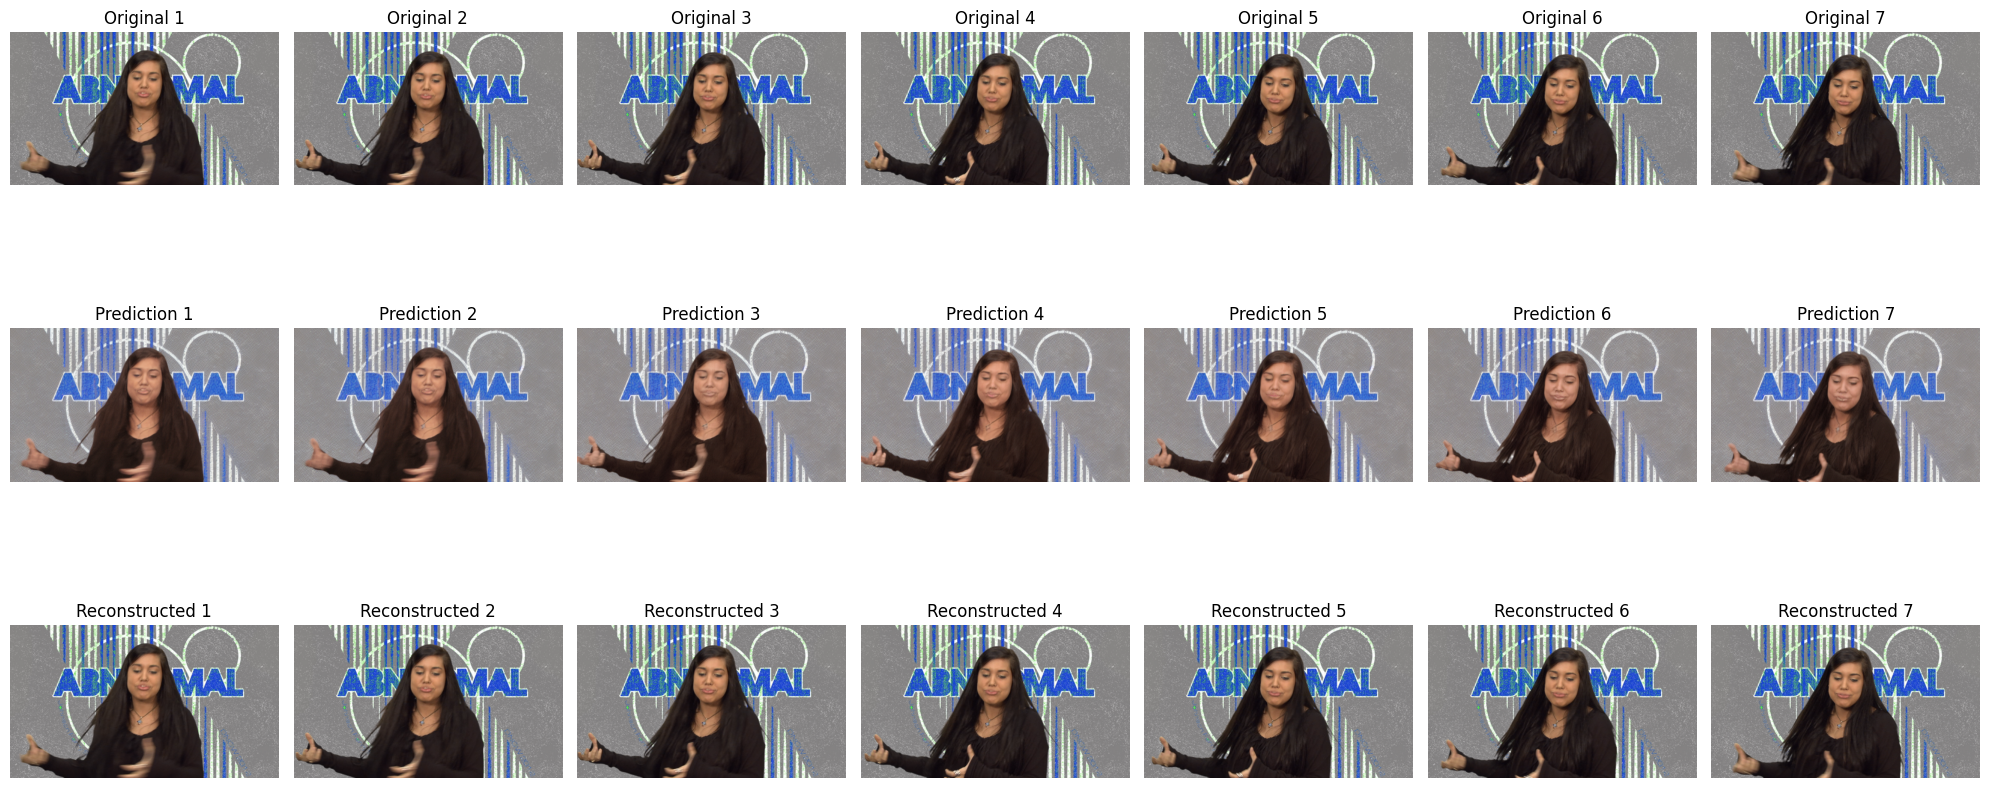

In [16]:
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt

# def get_recons_img(prompt, original_image, local_image):
#     # Resize images to the same shape
#     original_image = cv2.resize(original_image, (local_image.shape[1], local_image.shape[0]))

#     pred = process(local_image, prompt, a_prompt, n_prompt, num_samples, image_resolution, ddim_steps, strength, scale, seed, eta, global_strength)
#     recons_img = pred[0][0]
#     recons_img = cv2.resize(recons_img, (original_image.shape[1], original_image.shape[0]))
#     residue = original_image - recons_img
#     return recons_img, residue

def main():
    # Pick a random video and sequence
    image_paths = sorted(glob.glob('data/00096_0576/*'))
    print(image_paths)
    
    prompt = 'a girl with black hair and black shirt standing infront grey and blue background '

    original_images = [cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB) for image_path in image_paths]

    reconstructed_images = []
    residues = []
    predictions = []

    for i, original_image in enumerate(original_images):
        if i == 0:
            pred_img, residue = get_recons_img(prompt, original_image, original_image)
        else:
            pred_img, residue = get_recons_img(prompt, original_image, reconstructed_images[-1])
        
        predictions.append(pred_img)
        residues.append(residue)
        reconstructed_images.append(pred_img + residue)

        # Save residue image
        residue_image_path = image_paths[i].replace(".png", "_residue.png")
        cv2.imwrite(residue_image_path, cv2.cvtColor(residue, cv2.COLOR_RGB2BGR))
        print(f"Saved residue image: {residue_image_path}")

    # Plot the original and reconstructed images
    fig, axes = plt.subplots(3, len(original_images), figsize=(20, 10))
    for i in range(len(original_images)):
        axes[0, i].imshow(original_images[i])
        axes[0, i].set_title(f"Original {i + 1}")
        axes[0, i].axis('off')
        axes[1, i].imshow(predictions[i])
        axes[1, i].set_title(f"Prediction {i + 1}")
        axes[1, i].axis('off')
        axes[2, i].imshow(reconstructed_images[i])
        axes[2, i].set_title(f"Reconstructed {i + 1}")
        axes[2, i].axis('off')

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()


In [3]:
import os

def get_folder_size(folder_path):
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(folder_path):
        for file in filenames:
            file_path = os.path.join(dirpath, file)
            # Skip if it is a symbolic link
            if not os.path.islink(file_path):
                print(file_path)
                size = os.path.getsize(file_path)
                print(size)
                total_size += size
    return total_size


folder_path = '../data/00096_0576_processed/compressed/'  # Change this to your folder path
size_in_bytes = get_folder_size(folder_path)
print(f"Total size of files in '{folder_path}' is {size_in_bytes} bytes")
total_pixels = 512*512*7
print((size_in_bytes*8)/total_pixels)

../data/00096_0576_processed/compressed/im4_seg.png.tfci
3512
../data/00096_0576_processed/compressed/im1_seg.png.tfci
1947
../data/00096_0576_processed/compressed/im4_canny.png.tfci
13365
../data/00096_0576_processed/compressed/im2_canny.png.tfci
13429
../data/00096_0576_processed/compressed/im1_canny.png.tfci
13341
../data/00096_0576_processed/compressed/im5_seg.png.tfci
3477
../data/00096_0576_processed/compressed/im7_seg.png.tfci
1750
../data/00096_0576_processed/compressed/im3_canny.png.tfci
13389
../data/00096_0576_processed/compressed/im3_seg.png.tfci
3410
../data/00096_0576_processed/compressed/im2_seg.png.tfci
2520
../data/00096_0576_processed/compressed/im5_canny.png.tfci
13393
../data/00096_0576_processed/compressed/im7_canny.png.tfci
13175
../data/00096_0576_processed/compressed/im6_canny.png.tfci
13300
../data/00096_0576_processed/compressed/im6_seg.png.tfci
1970
Total size of files in '../data/00096_0576_processed/compressed/' is 111978 bytes
